In [1]:
import os
os.chdir(os.getcwd() + '/..')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from iss.tools import Config
from iss.tools import Tools
from iss.models import SimpleConvAutoEncoder
from iss.models import ImageDataGeneratorWrapper
import pandas as pd
import datetime as dt
import time
import numpy as np
from dotenv import find_dotenv, load_dotenv
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
load_dotenv(find_dotenv())
cfg = Config(project_dir = os.getenv("PROJECT_DIR"), mode = os.getenv("MODE"))
model_type = 'simple_conv'
cfg.get('models')[model_type]['model_name'] = 'model_colab'

In [5]:
model = SimpleConvAutoEncoder(cfg.get('models')[model_type])

In [6]:
model.load("final_model_colab")

In [7]:
model.encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 27, 48, 3)         0         
_________________________________________________________________
enc_conv_1 (Conv2D)          (None, 27, 48, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 48, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 27, 48, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 24, 64)        0         
_________________________________________________________________
enc_conv_2 (Conv2D)          (None, 13, 24, 32)        18464     
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 24, 32)        128       
__________

In [8]:
filenames = Tools.list_directory_filenames('data/processed/models/autoencoder/train/k/')
generator_imgs = Tools.generator_np_picture_from_filenames(filenames, target_size = (27, 48), batch = 496, nb_batch = 2)

In [9]:
pictures_preds = Tools.encoded_pictures_from_generator(generator_imgs, model)

In [13]:
intermediate_output = pictures_preds.reshape((992, 3*6*16))

AttributeError: 'tuple' object has no attribute 'reshape'

In [12]:
intermediate_output.shape

(992, 288)

In [13]:
output_tnse = TSNE(n_components=2).fit_transform(intermediate_output)

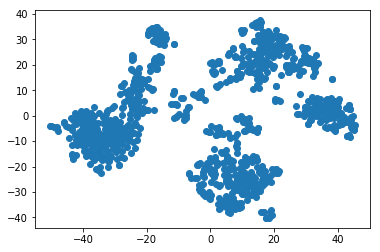

In [14]:
plt.scatter(
    output_tnse[:,0],
    output_tnse[:,1]
)
plt.show()

In [15]:
from sklearn.decomposition import PCA

In [16]:
intermediate_output.shape

(992, 288)

In [17]:
pca = PCA( n_components = 10)

In [18]:
pca.fit(intermediate_output)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [19]:
somme_cum = np.cumsum(pca.explained_variance_ratio_)
print(somme_cum)

[ 0.42109594  0.57931983  0.66647762  0.72199494  0.75129557  0.77454692
  0.79685652  0.81197721  0.82250977  0.83269101]


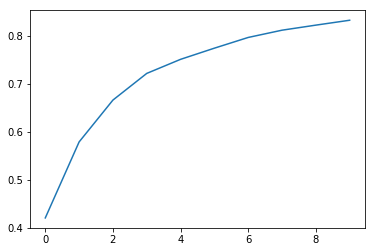

In [20]:
plt.plot(somme_cum[0:10])

In [21]:
reduction = pca.transform(intermediate_output)
print(reduction.shape)

(992, 10)


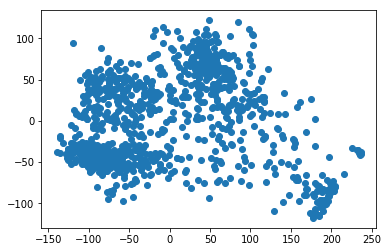

In [22]:
plt.scatter(reduction[:, 0], reduction[:, 1])

In [23]:
pca.components_.shape

(10, 288)

In [24]:
from sklearn.cluster import KMeans

In [25]:
km = KMeans(n_clusters=10)

In [26]:
km.fit(reduction)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [27]:
km.labels_[:10]

array([7, 1, 1, 2, 4, 3, 9, 5, 5, 6], dtype=int32)

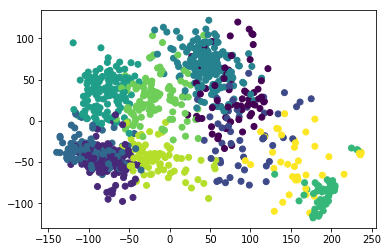

In [28]:
plt.scatter(reduction[:, 0], reduction[:, 1], c = km.labels_)

In [29]:
pca.explained_variance_ratio_

array([ 0.42109594,  0.15822393,  0.08715776,  0.05551729,  0.02930062,
        0.02325135,  0.02230961,  0.01512069,  0.01053257,  0.01018127], dtype=float32)

In [30]:
np.mean(reduction)

1.5381844e-06

In [31]:
centers = []
for cl in range(10):
    tmp = reduction[np.where(km.labels_ == cl)]
    print(cl)
    print(tmp.shape)
    centers.append(np.mean(tmp, axis = 0))

0
(71, 10)
1
(141, 10)
2
(52, 10)
3
(125, 10)
4
(194, 10)
5
(133, 10)
6
(58, 10)
7
(101, 10)
8
(78, 10)
9
(39, 10)


In [32]:
centers = np.array(centers)

In [33]:
centers.shape

(10, 10)

In [34]:
from sklearn.cluster import AgglomerativeClustering

In [35]:
cluster = AgglomerativeClustering(n_clusters = 4, affinity='euclidean', linkage='ward')  
cluster.fit_predict(centers)

array([2, 1, 2, 1, 2, 3, 0, 3, 1, 0])

In [36]:
cluster.labels_

array([2, 1, 2, 1, 2, 3, 0, 3, 1, 0])

In [37]:
km.labels_[0:10]

array([7, 1, 1, 2, 4, 3, 9, 5, 5, 6], dtype=int32)

In [38]:
new_cluster = [cluster.labels_[old_cl] for old_cl in km.labels_]

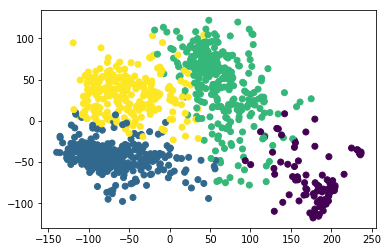

In [39]:
plt.scatter(reduction[:, 0], reduction[:, 1], c = new_cluster)

# Clustering avec la classe adequat

In [43]:
from iss.clustering import ClassicalClustering